In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# READ FROM DATABASE

In [2]:
import psycopg2

In [3]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

In [4]:
try:
    cur = conn.cursor()
    sql_query = pd.read_sql_query("SELECT m.postnr, m.dato, m.orgnummer, m.tilsynsbesoektype, m.total_karakter, c_sub.naeringskode1_kode, c_sub. \
                                  FROM mattilsynet m \
                                  JOIN company_subunit c_sub ON m.orgnummer = c_sub.organisasjonsnummer;", 
                                  conn)
    df_test = pd.DataFrame(sql_query, columns=['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'total_karakter', 'naeringskode1_kode'])
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_3804\1288020511.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_query = pd.read_sql_query("SELECT m.postnr, m.dato, m.orgnummer, m.tilsynsbesoektype, m.total_karakter, c_sub.naeringskode1_kode \


In [5]:
features_test = df_test[['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode']]
X = np.c_[features_test]
y = np.c_[df_test['total_karakter']]

In [6]:
print(f'X len : {len(X)}')
print(f'y len : {len(y)}')

X len : 5841
y len : 5841


In [7]:
print(X.data.shape,
y.data.shape)

(5841, 5) (5841, 1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4672
X_test len : 1169
y_train len : 4672
y_test len : 1169


# Naiv score

In [10]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}')

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}')

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') 

y_pred_naiv : 1169
Naiv MSE : 0.8857281678310638
Naiv MAE : 0.7442699605681006


# XGBoost Model

In [12]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 10
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode']])


[0]	validation_0-rmse:0.89169
[1]	validation_0-rmse:0.84235
[2]	validation_0-rmse:0.81830
[3]	validation_0-rmse:0.80731
[4]	validation_0-rmse:0.80147
[5]	validation_0-rmse:0.80388
[6]	validation_0-rmse:0.80560
[7]	validation_0-rmse:0.81075
[8]	validation_0-rmse:0.81338
[9]	validation_0-rmse:0.81416
[10]	validation_0-rmse:0.81452
[11]	validation_0-rmse:0.81668
[12]	validation_0-rmse:0.81809
[13]	validation_0-rmse:0.81898
[14]	validation_0-rmse:0.81945
[15]	validation_0-rmse:0.81974
[16]	validation_0-rmse:0.82336
[17]	validation_0-rmse:0.82285
[18]	validation_0-rmse:0.82490
[19]	validation_0-rmse:0.82528
[20]	validation_0-rmse:0.82707
[21]	validation_0-rmse:0.82859
[22]	validation_0-rmse:0.82896
[23]	validation_0-rmse:0.82940
[24]	validation_0-rmse:0.82938


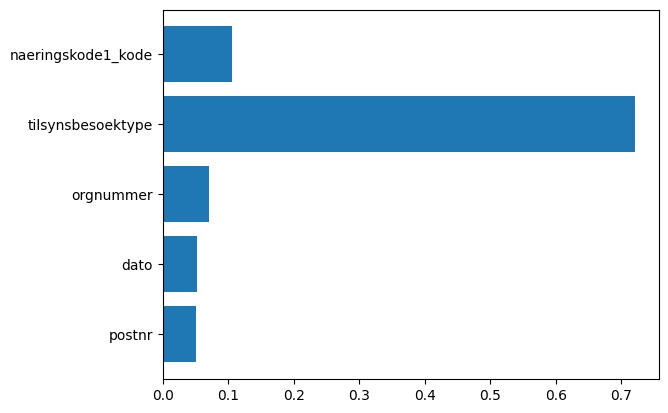

In [13]:
plt.barh(['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode'], regressor.feature_importances_)
plt.show()

# Scoring xg

In [14]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}')

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}')

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') 

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') 

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') 

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}')

Train R2 XG : 0.48599713132742806
Train MSE XG : 0.6495163335347284
Train MAE XG : 0.49809098763515763
Test R2 XG : 0.1811672180836833
Test MSE XG : 0.8014731904381543
Train MAE XG : 0.6227289195418664
